In [1]:
import pickle
import pandas as pd
import seaborn as sns

In [2]:
# read ../benchmarks_results.pickle
with open('../benchmark_results2.pickle', 'rb') as f:
    results = pickle.load(f)

In [3]:
results

{'python': {'SequentialEvaluator': [0.3865063190005458,
   0.3643158989998483,
   0.3560066310001275,
   0.3597635909991368,
   0.3623027200010256,
   0.36675997200109123,
   0.35991079900122713,
   0.3611500420010998,
   0.35814354800095316,
   0.3587555690010049],
  'MultiprocessingEvaluator': [2.673186595000516,
   2.733732004000558,
   2.6721464460006246,
   2.7282013519998145,
   2.6642299679988355,
   2.6902243979984632,
   2.7598871649988723,
   2.7439135660006286,
   2.663925458999074,
   2.6688326860003144],
  'MPIEvaluator': [6.94458096299968,
   2.8124233759990602,
   3.6920230319992697,
   2.906339848999778,
   3.712365168999895,
   2.924761385000238,
   3.130107789000249,
   3.073719625999729,
   3.220828845000142,
   3.4927063009999983]},
 'lake': {'SequentialEvaluator': [13.639044547000594,
   13.199893367000186,
   13.281513566000285,
   13.416122939999696,
   13.011374498000805,
   13.31042532599895,
   13.119177722999666,
   13.11690650699893,
   12.940034432000175,
 

In [4]:
# Step 1: Flatten the nested dictionary
flattened_data = []
for model_name, evaluator_data in results.items():
    for evaluator_name, time_taken in evaluator_data.items():
        for time_value in time_taken:
            flattened_data.append((model_name, evaluator_name, time_value))

# Step 2: Convert the flattened data into a pandas DataFrame
df = pd.DataFrame(flattened_data, columns=["Model", "Evaluator", "TimeTaken"])
df.head()

,Model,Evaluator,TimeTaken
0,python,SequentialEvaluator,0.386506
1,python,SequentialEvaluator,0.364316
2,python,SequentialEvaluator,0.356007
3,python,SequentialEvaluator,0.359764
4,python,SequentialEvaluator,0.362303


<Axes: xlabel='Evaluator', ylabel='TimeTaken'>

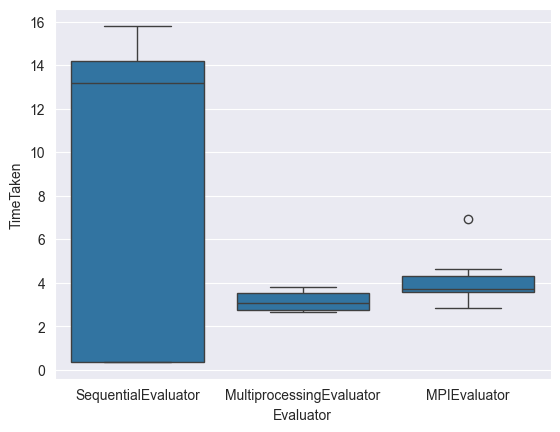

In [5]:
# For each evaluator, create a boxplot with Seaborn
sns.boxplot(x="Evaluator", y="TimeTaken", data=df)

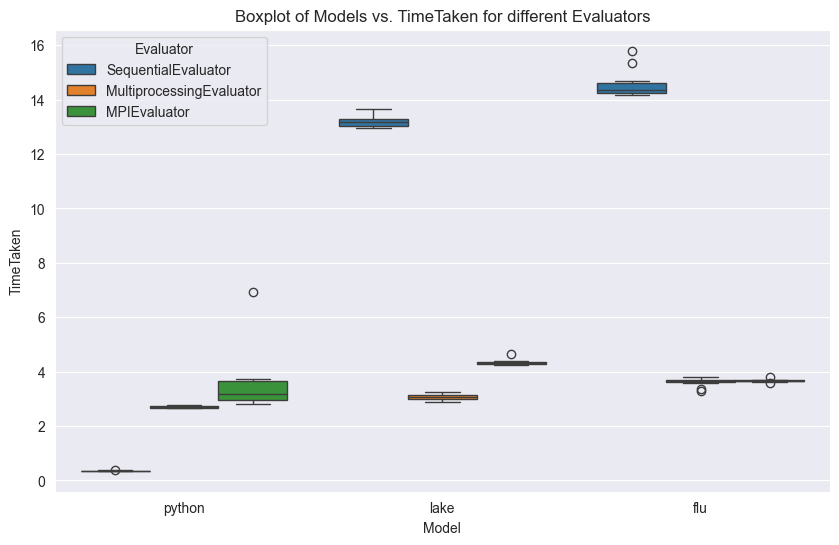

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Model", y="TimeTaken", hue="Evaluator")
plt.title("Boxplot of Models vs. TimeTaken for different Evaluators")
plt.show()

In [7]:
experiments_dict = {
    "python": 10000,
    "lake": 1000,
    "flu": 250,
}

C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Ewout\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


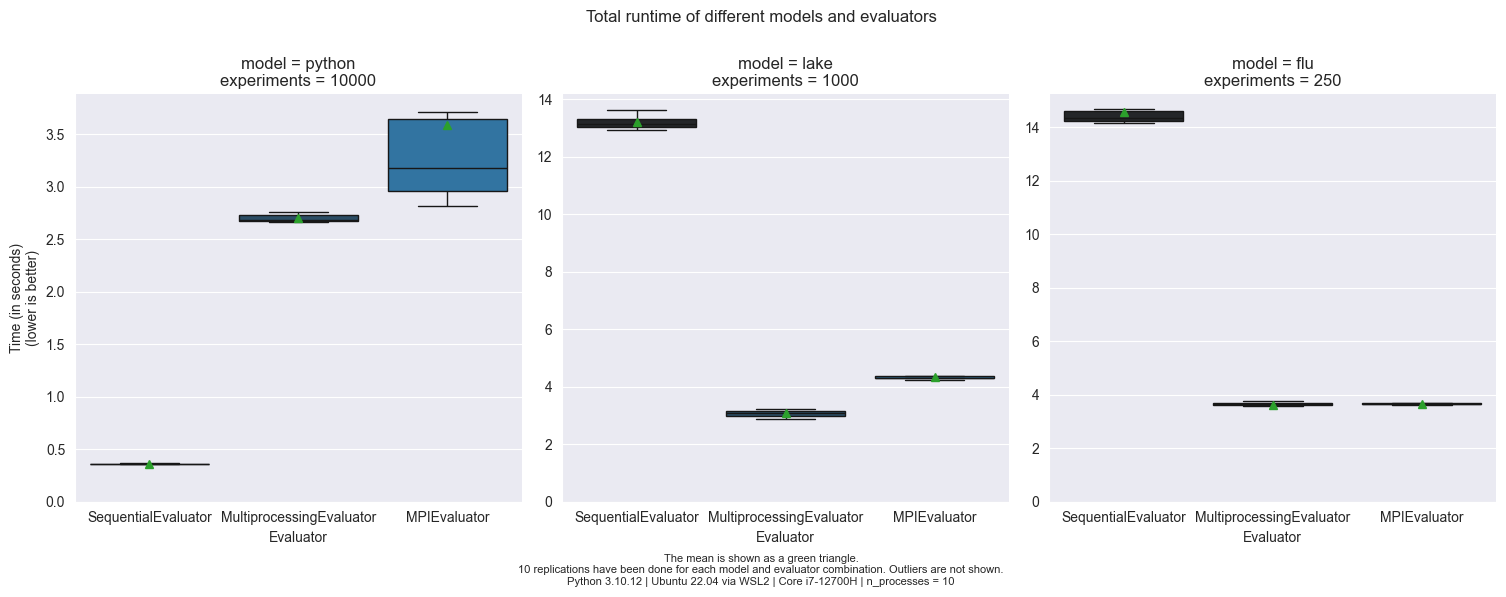

In [8]:
# Assuming df is your dataframe
unique_evaluators = df["Evaluator"].unique()
palette = sns.color_palette("pastel", len(unique_evaluators))

g = sns.FacetGrid(df, col="Model", col_wrap=3, height=5, sharey=False)
g = g.map_dataframe(sns.boxplot, x="Evaluator", y="TimeTaken", hue="Evaluator", showmeans=True, showfliers=False)
# Set y-axis label
g.set_axis_labels("Evaluator", "Time (in seconds)\n(lower is better)")
# Set subplot titles
for ax, title in zip(g.axes.flat, df["Model"].unique()):
    ax.set_title(f"model = {title}\nexperiments = {experiments_dict[title]}")
# set title
g.fig.suptitle("Total runtime of different models and evaluators", y=1.1)
g.set(ylim=(0, None))
# Add subscript
g.fig.text(0.5, -0.05, "The mean is shown as a green triangle.\n10 replications have been done for each model and evaluator combination. Outliers are not shown.\nPython 3.10.12 | Ubuntu 22.04 via WSL2 | Core i7-12700H | n_processes = 10", ha="center", fontsize=8)

plt.show()

# Save figure as svg
g.savefig("boxplot.svg")

In [9]:
# Calculate the average time taken for each model and evaluator
mean_df = df.groupby(["Model", "Evaluator"]).mean()
mean_df

TimeTaken
Model  Evaluator                          
flu    MPIEvaluator               3.667059
       MultiprocessingEvaluator   3.608181
       SequentialEvaluator       14.581752
lake   MPIEvaluator               4.347404
       MultiprocessingEvaluator   3.072983
       SequentialEvaluator       13.202655
python MPIEvaluator               3.590986
       MultiprocessingEvaluator   2.699828
       SequentialEvaluator        0.363362

In [10]:
# Convert to table, with the evaluators as columns
mean_df = mean_df.reset_index().pivot(index="Model", columns="Evaluator", values="TimeTaken")
mean_df

Evaluator,MPIEvaluator,MultiprocessingEvaluator,SequentialEvaluator
Model,,,
flu,3.667059,3.608181,14.581752
lake,4.347404,3.072983,13.202655
python,3.590986,2.699828,0.363362


In [11]:
# normalize on SequentialEvaluator
mean_df = mean_df.div(mean_df["SequentialEvaluator"], axis=0)

In [12]:
# Take the inverse, so that higher is better
mean_df = 1 / mean_df

In [13]:
# Revert the column and row order
mean_df = mean_df[["SequentialEvaluator", "MultiprocessingEvaluator", "MPIEvaluator"]]
mean_df = mean_df.reindex(["python", "lake", "flu"])

In [14]:
# Color the table, with green above 1, and red below 1
def color_red_green(val):
    color = 'green' if val > 1 else 'red'
    return 'color: %s' % color

mean_df.style.applymap(color_red_green)

C:\Users\Ewout\AppData\Local\Temp\ipykernel_32408\3057898379.py:6: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  mean_df.style.applymap(color_red_green)


Evaluator,SequentialEvaluator,MultiprocessingEvaluator,MPIEvaluator
Model,,,
python,1.000000,0.134587,0.101187
lake,1.000000,4.296364,3.036905
flu,1.000000,4.041302,3.976416


In [15]:
# Round to two decimal places
mean_df = mean_df.round(3)
mean_df

Evaluator,SequentialEvaluator,MultiprocessingEvaluator,MPIEvaluator
Model,,,
python,1.0,0.135,0.101
lake,1.0,4.296,3.037
flu,1.0,4.041,3.976


In [16]:
# convert to markdown table
print(mean_df.to_markdown())

| Model   |   SequentialEvaluator |   MultiprocessingEvaluator |   MPIEvaluator |
|:--------|----------------------:|---------------------------:|---------------:|
| python  |                     1 |                      0.135 |          0.101 |
| lake    |                     1 |                      4.296 |          3.037 |
| flu     |                     1 |                      4.041 |          3.976 |


In [17]:
# Divide the MultiprocessingEvaluator and MPIEvaluator by 10
mean_df["MultiprocessingEvaluator"] = mean_df["MultiprocessingEvaluator"] / 10
mean_df["MPIEvaluator"] = mean_df["MPIEvaluator"] / 10
print(mean_df.to_markdown())

| Model   |   SequentialEvaluator |   MultiprocessingEvaluator |   MPIEvaluator |
|:--------|----------------------:|---------------------------:|---------------:|
| python  |                     1 |                     0.0135 |         0.0101 |
| lake    |                     1 |                     0.4296 |         0.3037 |
| flu     |                     1 |                     0.4041 |         0.3976 |


### Scaling

In [18]:
# Create list from 0.25 to 32 in powers of 2
node_list = [2 ** i for i in range(-2, 6)]
node_list

[0.25, 0.5, 1, 2, 4, 8, 16, 32]

#### 25.000 lake model, non-exclusive

In [19]:
# Read all pickles in, they're in this format: benchmark_results_DelftBlue_scaling2_4.0nodes.pickle
import pickle

results = {}
for n in node_list[:7]:
    with open(f"bench/benchmark_results_DelftBlue_scaling2_{float(n)}nodes.pickle", "rb") as f:
        results[n] = pickle.load(f)

In [20]:
# Create dataframe in long form
flattened_data = []
for n, evaluator_data in results.items():
    for time_value in evaluator_data:
        flattened_data.append((n, time_value))

df = pd.DataFrame(flattened_data, columns=["Nodes", "TimeTaken"])
df.head(3)

,Nodes,TimeTaken
0,0.25,138.297459
1,0.25,128.580002
2,0.25,128.059598


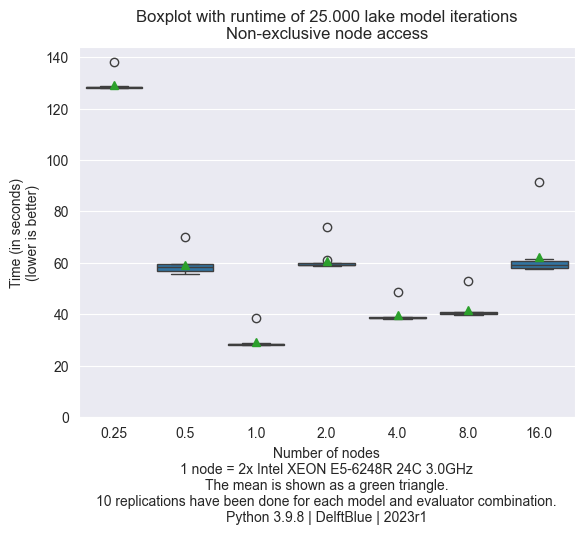

In [21]:
# Create boxplot
g = sns.boxplot(x="Nodes", y="TimeTaken", data=df, showmeans=True)
g.set(ylim=(0, None))
g.set_title("Boxplot with runtime of 25.000 lake model iterations\nNon-exclusive node access", ha="center")
g.set_ylabel("Time (in seconds)\n(lower is better)")
g.set_xlabel("Number of nodes\n1 node = 2x Intel XEON E5-6248R 24C 3.0GHz\nThe mean is shown as a green triangle.\n10 replications have been done for each model and evaluator combination.\nPython 3.9.8 | DelftBlue | 2023r1")
g.figure.savefig("boxplot_lake.svg", bbox_inches="tight")

#### 100.000 lake model, exclusive

In [22]:
results_exclusive = {}
for n in node_list[2:]:
    with open(f"bench/benchmark_results_DelftBlue_scaling2_{float(n)}nodes_exclusive.pickle", "rb") as f:
        results_exclusive[n] = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'bench/benchmark_results_DelftBlue_scaling2_16.0nodes_exclusive.pickle'

In [23]:
flattened_data = []
for n, evaluator_data in results_exclusive.items():
    for time_value in evaluator_data:
        flattened_data.append((n, time_value))

dfe = pd.DataFrame(flattened_data, columns=["Nodes", "TimeTaken"])
dfe.head(3)

,Nodes,TimeTaken
0,1,130.953895
1,1,114.692291
2,1,114.624035


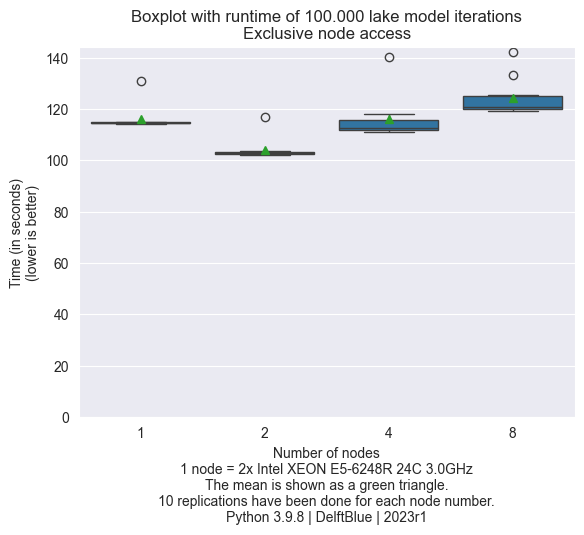

In [24]:
# Create boxplot
g = sns.boxplot(x="Nodes", y="TimeTaken", data=dfe, showmeans=True)
g.set(ylim=(0, None))
g.set_title("Boxplot with runtime of 100.000 lake model iterations\nExclusive node access", ha="center")
g.set_ylabel("Time (in seconds)\n(lower is better)")
g.set_xlabel("Number of nodes\n1 node = 2x Intel XEON E5-6248R 24C 3.0GHz\nThe mean is shown as a green triangle.\n10 replications have been done for each node number.\nPython 3.9.8 | DelftBlue | 2023r1")
g.figure.savefig("boxplot_lake_exclusive.svg", bbox_inches="tight")

#### 25.000 flu model, exclusive

In [25]:
results_flu = {}
for n in node_list:
    with open(f"bench/benchmark_results_DelftBlue_scaling2_{float(n)}nodes_exclusive_flu.pickle", "rb") as f:
        results_flu[n] = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'bench/benchmark_results_DelftBlue_scaling2_16.0nodes_exclusive_flu.pickle'

In [26]:
flattened_data = []
for n, evaluator_data in results_flu.items():
    for time_value in evaluator_data:
        flattened_data.append((n, time_value))

dfu = pd.DataFrame(flattened_data, columns=["Nodes", "TimeTaken"])
dfu.head(3)

,Nodes,TimeTaken
0,0.25,381.728433
1,0.25,373.404528
2,0.25,371.465420


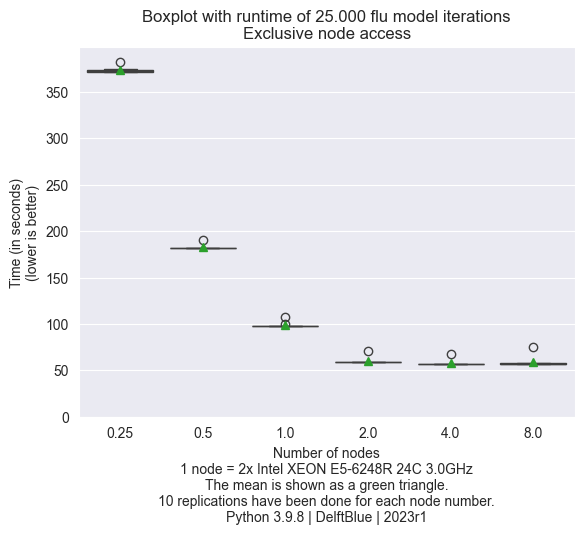

In [27]:
# Create boxplot
g = sns.boxplot(x="Nodes", y="TimeTaken", data=dfu, showmeans=True)
g.set(ylim=(0, None))
g.set_title("Boxplot with runtime of 25.000 flu model iterations\nExclusive node access", ha="center")
g.set_ylabel("Time (in seconds)\n(lower is better)")
g.set_xlabel("Number of nodes\n1 node = 2x Intel XEON E5-6248R 24C 3.0GHz\nThe mean is shown as a green triangle.\n10 replications have been done for each node number.\nPython 3.9.8 | DelftBlue | 2023r1")
g.figure.savefig("boxplot_flu.svg", bbox_inches="tight")